In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model
try:
    from peft import TaskType
    task_type = TaskType.SEQ_CLS
except ImportError:
    # For older PEFT versions, use string directly
    task_type = "SEQ_CLS"
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset, WeightedRandomSampler
from torch import nn
from sklearn.model_selection import train_test_split

from peft import LoraConfig
from transformers import TrainingArguments





In [ ]:
drive.mount('/content/drive')
truth_df = pd.read_csv('/content/drive/MyDrive/TruthSocial/truth_cleand.csv')
print(truth_df.shape)
truth_df.head()

Mounted at /content/drive
(656365, 14)


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,0.489587,neutral,0,0.029001
2,807619,7,20054,0,0,0,@user,0,0.001936,1,0.681377,neutral,0,0.037486
3,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844
4,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,0.861522,neutral,0,0.011909




> Blockzitat einfügen



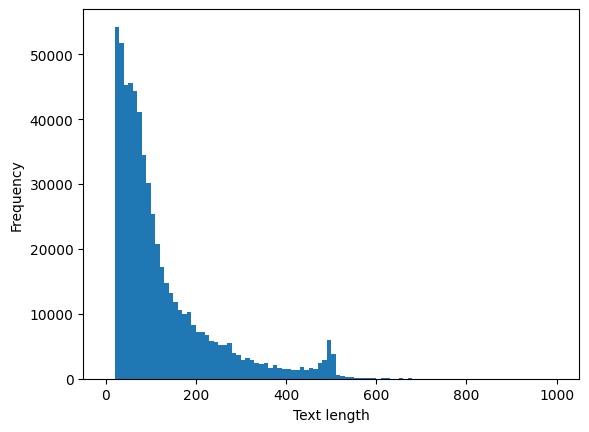

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

def clean_text(t):
    if pd.isna(t):
        return ""
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)       # remove URLs
    t = re.sub(r"@\w+", "@user", t)     # normalize mentions
    t = re.sub(r"\s+", " ", t).strip() # normalize whitespace
    return t

# clean text
truth_df['text'] = truth_df['text'].apply(clean_text)

# remove rows where text length < 20
truth_df = truth_df[truth_df['text'].str.len() >= 20]

# compute text lengths
text_lengths = truth_df['text'].str.len()

# histogram with bin width = 10
bins = np.arange(0, text_lengths.max() + 10, 10)

plt.hist(text_lengths, bins=bins)
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#load weak lables:
weak_labels = pd.read_csv('/content/drive/MyDrive/TruthSocial/truth_labels_prefilterd_gpt5.csv')
print(weak_labels.head())
df_joined = pd.merge(truth_df, weak_labels, on='id', how='inner')
print(df_joined)
df_joined.head()

   Unnamed: 0      id  TRUE  FALSE  NO_STATEMENT   truth_label
0           0  807621  0.02   0.08          0.90  NO_STATEMENT
1           1  703306  0.05   0.05          0.90  NO_STATEMENT
2           2  703308  0.05   0.60          0.35         FALSE
3           3  703394  0.15   0.15          0.70  NO_STATEMENT
4           4  703282  0.02   0.08          0.90  NO_STATEMENT
           id  timestamp  author  like_count  retruth_count  reply_count  \
0      807621          6   20054           0              0            0   
1      703306         24   11225          12              4            6   
2      703308         24   11225          86             54           11   
3      703394         23   11225          16              0            0   
4      703282         24   11225           8              2            1   
...       ...        ...     ...         ...            ...          ...   
25015  934271          4   21566           0              0            0   
25016  934269 

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,Unnamed: 0,TRUE,FALSE,NO_STATEMENT,truth_label
0,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,0,0.02,0.08,0.90,NO_STATEMENT
1,703306,24,11225,12,4,6,jesus act of mercy on him is not for me to arg...,0,0.001281,1,0.577395,neutral,1,0.843496,1,0.05,0.05,0.90,NO_STATEMENT
2,703308,24,11225,86,54,11,our government lied..they never reported any s...,0,0.024585,0,0.869792,negative,1,0.917135,2,0.05,0.60,0.35,FALSE
3,703394,23,11225,16,0,0,just like the windmills failed in texas snow s...,1,0.800656,0,0.942177,negative,1,0.724487,3,0.15,0.15,0.70,NO_STATEMENT
4,703282,24,11225,8,2,1,if god had not promised noah he would never de...,1,0.825542,0,0.430576,negative,1,0.695649,4,0.02,0.08,0.90,NO_STATEMENT


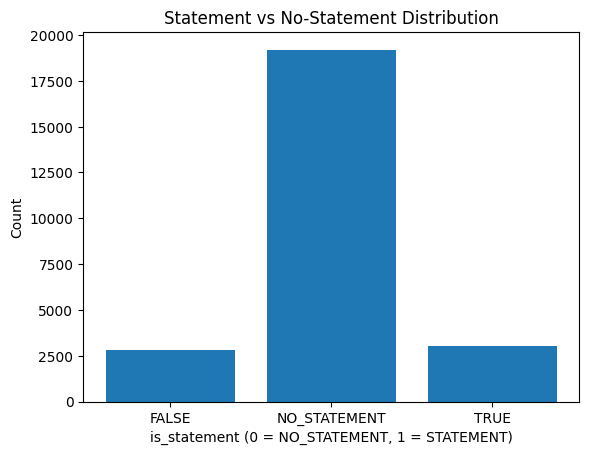

In [ ]:
# Statment detecktion

counts = df_joined["truth_label"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("is_statement (0 = NO_STATEMENT, 1 = STATEMENT)")
plt.ylabel("Count")
plt.title("Statement vs No-Statement Distribution")
plt.show()



# Neuer Abschnitt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    get_cosine_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from torch.optim import AdamW

# Text Preprocessing
class SocialMediaPreprocessor:
    @staticmethod
    def clean_text(text):
        import re
        if pd.isna(text):
            return ""

        text = str(text)
        text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
        text = re.sub(r'@\w+', '[USER]', text)
        text = re.sub(r'([!?.]){2,}', r'\1\1', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

# Dataset mit Soft Labels
class SoftLabelDataset(Dataset):
    def __init__(self, texts, label_distributions, tokenizer, max_length=256, preprocess=True):
        """
        Args:
            texts: Liste von Texten
            label_distributions: numpy array (N, 3) mit Wahrscheinlichkeitsverteilungen
                                z.B. [[0.90, 0.05, 0.05], [0.35, 0.60, 0.05], ...]
                                für [NO_STATEMENT, TRUE, FALSE]
            tokenizer: HuggingFace Tokenizer
            max_length: Maximale Sequenzlänge
        """
        self.preprocessor = SocialMediaPreprocessor()

        if preprocess:
            self.texts = [self.preprocessor.clean_text(t) for t in texts]
        else:
            self.texts = texts

        # Validiere und normalisiere Label-Verteilungen
        self.label_distributions = np.array(label_distributions, dtype=np.float32)

        # Stelle sicher, dass Verteilungen zu 1 summieren
        row_sums = self.label_distributions.sum(axis=1, keepdims=True)
        self.label_distributions = self.label_distributions / (row_sums + 1e-10)

        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label_dist = self.label_distributions[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label_distribution': torch.tensor(label_dist, dtype=torch.float32)
        }

# Loss Functions für Soft Labels
class KLDivergenceLoss(nn.Module):
    """KL Divergence Loss für Wahrscheinlichkeitsverteilungen"""
    def __init__(self, temperature=1.0, reduction='batchmean'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction

    def forward(self, predictions, targets):
        """
        Args:
            predictions: Model logits (batch_size, num_classes)
            targets: Target distributions (batch_size, num_classes)
        """
        # Log-Softmax der Predictions
        log_pred = F.log_softmax(predictions / self.temperature, dim=1)

        # KL Divergence
        loss = F.kl_div(log_pred, targets, reduction=self.reduction)

        return loss * (self.temperature ** 2)  # Scale by temperature squared

class JensenShannonDivergence(nn.Module):
    """JS Divergence - symmetrische Version von KL Divergence"""
    def __init__(self, reduction='batchmean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, predictions, targets):
        # Softmax der Predictions
        pred_probs = F.softmax(predictions, dim=1)

        # Mittlere Verteilung
        m = 0.5 * (pred_probs + targets)

        # KL(pred || m) + KL(target || m)
        kl_pred_m = F.kl_div(F.log_softmax(predictions, dim=1), m, reduction=self.reduction)
        kl_target_m = F.kl_div(torch.log(targets + 1e-10), m, reduction=self.reduction)

        return 0.5 * (kl_pred_m + kl_target_m)

class SoftFocalLoss(nn.Module):
    """Focal Loss für Soft Labels mit Klassengewichtung"""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Klassengewichte (optional)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):
        """
        Args:
            predictions: Model logits (batch_size, num_classes)
            targets: Target distributions (batch_size, num_classes)
        """
        # Softmax der Predictions
        pred_probs = F.softmax(predictions, dim=1)

        # Cross Entropy zwischen target und prediction distributions
        ce_loss = -(targets * torch.log(pred_probs + 1e-10)).sum(dim=1)

        # Focal weight: (1 - p_t)^gamma
        # p_t ist die predicted probability für die target distribution
        p_t = (targets * pred_probs).sum(dim=1)
        focal_weight = (1 - p_t) ** self.gamma

        # Klassengewichtung (optional)
        if self.alpha is not None:
            alpha_t = (targets * self.alpha.unsqueeze(0)).sum(dim=1)
            focal_loss = alpha_t * focal_weight * ce_loss
        else:
            focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Hauptklasse
class SoftLabelTruthClassifier:
    def __init__(self, model_name='microsoft/deberta-v3-base', num_labels=3, device=None):
        """
        Classifier mit Soft Label Training

        Args:
            model_name: HuggingFace Model
            num_labels: Anzahl Klassen (3: NO_STATEMENT, TRUE, FALSE)
        """
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        ).to(self.device)

        self.num_labels = num_labels
        self.label_map = {0: 'NO_STATEMENT', 1: 'TRUE', 2: 'FALSE'}

    def prepare_data(self, texts, label_distributions, batch_size=16, max_length=256,
                     test_size=0.2, random_state=42):
        """
        Bereitet Daten vor

        Args:
            texts: Liste von Texten
            label_distributions: Array (N, 3) mit [p_NO_STATEMENT, p_TRUE, p_FALSE]
        """
        # Train/Val Split - stratifiziert nach dominanter Klasse
        dominant_labels = np.argmax(label_distributions, axis=1)

        indices = np.arange(len(texts))
        train_idx, val_idx = train_test_split(
            indices,
            test_size=test_size,
            stratify=dominant_labels,
            random_state=random_state
        )

        X_train = [texts[i] for i in train_idx]
        X_val = [texts[i] for i in val_idx]
        y_train = label_distributions[train_idx]
        y_val = label_distributions[val_idx]

        # Datasets
        train_dataset = SoftLabelDataset(X_train, y_train, self.tokenizer, max_length)
        val_dataset = SoftLabelDataset(X_val, y_val, self.tokenizer, max_length)

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

        return train_loader, val_loader, y_train, y_val

    def train(self, train_loader, val_loader, train_label_dists,
              epochs=4, learning_rate=2e-5, warmup_ratio=0.1,
              loss_type='kl', temperature=1.0, focal_gamma=2.0,
              weight_decay=0.01):
        """
        Training mit Soft Labels

        Args:
            loss_type: 'kl' (KL Divergence), 'js' (Jensen-Shannon), 'focal' (Soft Focal Loss)
            temperature: Temperature für KL Divergence (höher = weicher)
            focal_gamma: Gamma für Focal Loss
        """

        # Berechne Klassengewichte aus der Verteilung
        avg_class_probs = train_label_dists.mean(axis=0)
        class_weights = 1.0 / (avg_class_probs + 1e-10)
        class_weights = class_weights / class_weights.sum() * self.num_labels
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(self.device)

        print(f"Average class probabilities: {avg_class_probs}")
        print(f"Class weights: {class_weights}")

        # Loss Function auswählen
        if loss_type == 'kl':
            criterion = KLDivergenceLoss(temperature=temperature)
            print(f"Using KL Divergence Loss (temperature={temperature})")
        elif loss_type == 'js':
            criterion = JensenShannonDivergence()
            print("Using Jensen-Shannon Divergence Loss")
        elif loss_type == 'focal':
            criterion = SoftFocalLoss(alpha=class_weights_tensor, gamma=focal_gamma)
            print(f"Using Soft Focal Loss (gamma={focal_gamma})")
        else:
            raise ValueError(f"Unknown loss_type: {loss_type}")

        # Optimizer
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.model.named_parameters()
                          if not any(nd in n for nd in no_decay)],
                'weight_decay': weight_decay,
            },
            {
                'params': [p for n, p in self.model.named_parameters()
                          if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0,
            }
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

        # Scheduler
        total_steps = len(train_loader) * epochs
        warmup_steps = int(warmup_ratio * total_steps)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        best_val_loss = float('inf')
        best_model_state = None

        for epoch in range(epochs):
            print(f"\n{'='*70}")
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"{'='*70}")

            # Training
            self.model.train()
            train_loss = 0

            progress_bar = tqdm(train_loader, desc="Training")
            for batch in progress_bar:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                label_dist = batch['label_distribution'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, label_dist)
                train_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

            avg_train_loss = train_loss / len(train_loader)

            # Validation
            val_loss, val_preds, val_true_dists, val_pred_probs = self._validate(val_loader, criterion)

            # Metriken für dominante Klasse
            val_hard_preds = np.argmax(val_pred_probs, axis=1)
            val_hard_true = np.argmax(val_true_dists, axis=1)
            val_f1 = f1_score(val_hard_true, val_hard_preds, average='macro')

            # JS Divergence als zusätzliche Metrik
            js_div = self._compute_js_divergence(val_pred_probs, val_true_dists)

            print(f"\nTrain Loss: {avg_train_loss:.4f}")
            print(f"Val Loss:   {val_loss:.4f}")
            print(f"Val F1 (hard labels): {val_f1:.4f}")
            print(f"Val JS Divergence: {js_div:.4f}")

            print("\nClassification Report (on dominant class):")
            print(classification_report(
                val_hard_true, val_hard_preds,
                target_names=['NO_STATEMENT', 'TRUE', 'FALSE'],
                digits=4
            ))

            # Zeige Beispiele
            self._show_prediction_examples(val_loader, n_examples=3)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = self.model.state_dict().copy()
                print(f"✓ New best validation loss: {best_val_loss:.4f}")

        # Load best model
        if best_model_state:
            self.model.load_state_dict(best_model_state)
            print("\n✓ Training completed! Best model loaded.")

    def _validate(self, val_loader, criterion):
        """Validation Loop"""
        self.model.eval()
        val_loss = 0
        all_preds = []
        all_true_dists = []
        all_pred_probs = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                label_dist = batch['label_distribution'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, label_dist)
                val_loss += loss.item()

                pred_probs = F.softmax(logits, dim=1).cpu().numpy()
                preds = np.argmax(pred_probs, axis=1)

                all_preds.extend(preds)
                all_true_dists.extend(label_dist.cpu().numpy())
                all_pred_probs.extend(pred_probs)

        return (val_loss / len(val_loader),
                np.array(all_preds),
                np.array(all_true_dists),
                np.array(all_pred_probs))

    def _compute_js_divergence(self, pred_probs, true_dists):
        """Berechnet durchschnittliche JS Divergence"""
        m = 0.5 * (pred_probs + true_dists)
        kl_pred = np.sum(pred_probs * np.log((pred_probs + 1e-10) / (m + 1e-10)), axis=1)
        kl_true = np.sum(true_dists * np.log((true_dists + 1e-10) / (m + 1e-10)), axis=1)
        return 0.5 * (kl_pred + kl_true).mean()

    def _show_prediction_examples(self, loader, n_examples=3):
        """Zeigt Beispiel-Predictions"""
        self.model.eval()
        count = 0

        print(f"\n{'─'*70}")
        print("Example Predictions:")
        print(f"{'─'*70}")

        with torch.no_grad():
            for batch in loader:
                if count >= n_examples:
                    break

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                true_dist = batch['label_distribution'].numpy()

                outputs = self.model(input_ids, attention_mask=attention_mask)
                pred_probs = F.softmax(outputs.logits, dim=1).cpu().numpy()

                # Dekodiere Text
                for i in range(min(len(input_ids), n_examples - count)):
                    tokens = input_ids[i].cpu().numpy()
                    text = self.tokenizer.decode(tokens, skip_special_tokens=True)

                    print(f"\nExample {count + 1}:")
                    print(f"Text: {text[:100]}...")
                    print(f"True dist:  NO_STMT={true_dist[i][0]:.3f}, TRUE={true_dist[i][1]:.3f}, FALSE={true_dist[i][2]:.3f}")
                    print(f"Pred dist:  NO_STMT={pred_probs[i][0]:.3f}, TRUE={pred_probs[i][1]:.3f}, FALSE={pred_probs[i][2]:.3f}")

                    count += 1
                    if count >= n_examples:
                        break

    def predict(self, texts, batch_size=16, max_length=256):
        """
        Predictions für neue Texte

        Returns:
            hard_predictions: Argmax der Wahrscheinlichkeiten
            soft_predictions: Volle Wahrscheinlichkeitsverteilung
        """
        self.model.eval()

        dataset = SoftLabelDataset(
            texts,
            np.zeros((len(texts), self.num_labels)),  # Dummy distributions
            self.tokenizer,
            max_length
        )
        loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

        all_probs = []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                probs = F.softmax(outputs.logits, dim=1).cpu().numpy()
                all_probs.extend(probs)

        all_probs = np.array(all_probs)
        hard_predictions = np.argmax(all_probs, axis=1)

        return hard_predictions, all_probs

    def save_model(self, path):
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"✓ Model saved to {path}")

    def load_model(self, path):
        self.model = AutoModelForSequenceClassification.from_pretrained(path).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(path)
        print(f"✓ Model loaded from {path}")


# Beispiel-Nutzung
def run():

    # 1. Daten laden
    df = df_joined.copy()

    texts = df['text'].values

    # WICHTIG: Erstelle Wahrscheinlichkeitsverteilungen aus deinen Spalten
    label_distributions = df[['NO_STATEMENT', 'TRUE', 'FALSE']].values
    # Sollte ein numpy array sein: shape (N, 3)
    # Jede Zeile summiert zu ~1.0

    # Falls du noch normalisieren musst:
    label_distributions = label_distributions / label_distributions.sum(axis=1, keepdims=True)

    # 2. Model initialisieren
    classifier = SoftLabelTruthClassifier(
        model_name='microsoft/deberta-v3-base',
        num_labels=3
    )

    # 3. Daten vorbereiten
    train_loader, val_loader, y_train, y_val = classifier.prepare_data(
        texts,
        label_distributions,
        batch_size=32,
        max_length=256,
        test_size=0.2
    )

    # 4. Training - Wähle eine Loss Function:

    # Option A: KL Divergence (Standard für Soft Labels)
    #classifier.train(
    #    train_loader, val_loader, y_train,
    #    epochs=4,
    #    learning_rate=2e-5,
    #    loss_type='kl',
    #    temperature=1.0  # Höher = weichere Verteilungen
    #)

    # Option B: Jensen-Shannon Divergence (symmetrisch, robuster)
    # classifier.train(
    #     train_loader, val_loader, y_train,
    #     epochs=4,
    #     loss_type='js'
    # )

    # Option C: Soft Focal Loss (beste für Klassenungleichgewicht)
    classifier.train(
         train_loader, val_loader, y_train,
         epochs=10,
         loss_type='focal',
         focal_gamma=2.0
     )

    # 5. Predictions
    new_texts = [
        "Biden is destroying America!",
        "Nice weather today",
        "The election was stolen"
    ]

    hard_preds, soft_preds = classifier.predict(new_texts)

    for text, hard, soft in zip(new_texts, hard_preds, soft_preds):
        print(f"Text: {text}")
        print(f"Hard prediction: {classifier.label_map[hard]}")
        print(f"Soft prediction: NO_STMT={soft[0]:.3f}, TRUE={soft[1]:.3f}, FALSE={soft[2]:.3f}")
        print()

    # 6. Model speichern
    classifier.save_model('/content/drive/MyDrive/TruthSocial/truth/soft_label_classifier_focal_loss')
    return classifier


In [ ]:
classifier=run()

Using device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average class probabilities: [0.64544065 0.17044714 0.18411221]
Class weights: [0.36177525 1.36995227 1.26827248]
Using Soft Focal Loss (gamma=2.0)

Epoch 1/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]


Train Loss: 0.2501
Val Loss:   0.2080
Val F1 (hard labels): 0.5527
Val JS Divergence: 0.0495

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8213    0.9371    0.8754      3861
        TRUE     0.5489    0.3254    0.4086       587
       FALSE     0.6016    0.2716    0.3742       556

    accuracy                         0.7914      5004
   macro avg     0.6573    0.5113    0.5527      5004
weighted avg     0.7650    0.7914    0.7649      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.755, TRUE=0.169, FALSE=0.076

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.635, TRUE=0.253, FALSE=0.112

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.348, TRUE=0.455, FALSE=0.197
✓ New best validation loss: 0.2080

Epoch 2/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1970
Val Loss:   0.1956
Val F1 (hard labels): 0.6222
Val JS Divergence: 0.0515

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8858    0.7972    0.8391      3861
        TRUE     0.4308    0.5571    0.4859       587
       FALSE     0.4662    0.6457    0.5415       556

    accuracy                         0.7522      5004
   macro avg     0.5943    0.6667    0.6222      5004
weighted avg     0.7858    0.7522    0.7646      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.787, TRUE=0.139, FALSE=0.074

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.468, TRUE=0.457, FALSE=0.076

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.261, TRUE=0.553, FALSE=0.186
✓ New best validation loss: 0.1956

Epoch 3/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]


Train Loss: 0.1650
Val Loss:   0.1996
Val F1 (hard labels): 0.6445
Val JS Divergence: 0.0493

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8927    0.8120    0.8504      3861
        TRUE     0.4262    0.7036    0.5308       587
       FALSE     0.5698    0.5360    0.5524       556

    accuracy                         0.7686      5004
   macro avg     0.6296    0.6838    0.6445      5004
weighted avg     0.8021    0.7686    0.7798      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.807, TRUE=0.126, FALSE=0.068

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.363, TRUE=0.577, FALSE=0.060

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.259, TRUE=0.452, FALSE=0.289

Epoch 4/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1441
Val Loss:   0.1998
Val F1 (hard labels): 0.6484
Val JS Divergence: 0.0456

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8825    0.8519    0.8669      3861
        TRUE     0.4969    0.5486    0.5215       587
       FALSE     0.5246    0.5935    0.5570       556

    accuracy                         0.7876      5004
   macro avg     0.6347    0.6646    0.6484      5004
weighted avg     0.7975    0.7876    0.7919      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.832, TRUE=0.095, FALSE=0.072

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.421, TRUE=0.464, FALSE=0.115

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.274, TRUE=0.381, FALSE=0.344

Epoch 5/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1298
Val Loss:   0.2107
Val F1 (hard labels): 0.6479
Val JS Divergence: 0.0480

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8729    0.8809    0.8769      3861
        TRUE     0.5139    0.5673    0.5393       587
       FALSE     0.5826    0.4820    0.5276       556

    accuracy                         0.7998      5004
   macro avg     0.6565    0.6434    0.6479      5004
weighted avg     0.7986    0.7998    0.7985      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.871, TRUE=0.066, FALSE=0.063

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.269, TRUE=0.665, FALSE=0.066

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.237, TRUE=0.448, FALSE=0.315

Epoch 6/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1207
Val Loss:   0.2234
Val F1 (hard labels): 0.6461
Val JS Divergence: 0.0531

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8695    0.8832    0.8763      3861
        TRUE     0.5000    0.5230    0.5112       587
       FALSE     0.6026    0.5072    0.5508       556

    accuracy                         0.7992      5004
   macro avg     0.6573    0.6378    0.6461      5004
weighted avg     0.7965    0.7992    0.7973      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.924, TRUE=0.046, FALSE=0.031

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.173, TRUE=0.780, FALSE=0.047

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.208, TRUE=0.583, FALSE=0.208

Epoch 7/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]



Train Loss: 0.1147
Val Loss:   0.2131
Val F1 (hard labels): 0.6397
Val JS Divergence: 0.0514

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8886    0.8179    0.8518      3861
        TRUE     0.4870    0.5741    0.5270       587
       FALSE     0.4683    0.6385    0.5403       556

    accuracy                         0.7694      5004
   macro avg     0.6146    0.6768    0.6397      5004
weighted avg     0.7948    0.7694    0.7791      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────

Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.893, TRUE=0.059, FALSE=0.048

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.55

Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1115
Val Loss:   0.2286
Val F1 (hard labels): 0.6431
Val JS Divergence: 0.0574

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8890    0.8215    0.8540      3861
        TRUE     0.4496    0.6388    0.5278       587
       FALSE     0.5266    0.5701    0.5475       556

    accuracy                         0.7722      5004
   macro avg     0.6217    0.6768    0.6431      5004
weighted avg     0.7972    0.7722    0.7816      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.907, TRUE=0.058, FALSE=0.035

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.099, TRUE=0.854, FALSE=0.047

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.145, TRUE=0.724, FALSE=0.132

Epoch 9/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Train Loss: 0.1089
Val Loss:   0.2261
Val F1 (hard labels): 0.6499
Val JS Divergence: 0.0554

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8820    0.8516    0.8665      3861
        TRUE     0.4724    0.5826    0.5217       587
       FALSE     0.5634    0.5594    0.5614       556

    accuracy                         0.7876      5004
   macro avg     0.6393    0.6645    0.6499      5004
weighted avg     0.7985    0.7876    0.7922      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.920, TRUE=0.052, FALSE=0.028

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.113, TRUE=0.835, FALSE=0.053

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.190, TRUE=0.636, FALSE=0.173

Epoch 10/10


Validation: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]


Train Loss: 0.1079
Val Loss:   0.2258
Val F1 (hard labels): 0.6527
Val JS Divergence: 0.0551

Classification Report (on dominant class):
              precision    recall  f1-score   support

NO_STATEMENT     0.8819    0.8565    0.8690      3861
        TRUE     0.4824    0.5826    0.5278       587
       FALSE     0.5670    0.5558    0.5613       556

    accuracy                         0.7910      5004
   macro avg     0.6437    0.6650    0.6527      5004
weighted avg     0.8000    0.7910    0.7948      5004


──────────────────────────────────────────────────────────────────────
Example Predictions:
──────────────────────────────────────────────────────────────────────



Example 1:
Text: walker kessler's suit for the draft...
True dist:  NO_STMT=0.900, TRUE=0.050, FALSE=0.050
Pred dist:  NO_STMT=0.921, TRUE=0.051, FALSE=0.028

Example 2:
Text: highland park gunman dressed as girl to hide in plain sight after killing six before evading cops fo...
True dist:  NO_STMT=0.200, TRUE=0.550, FALSE=0.250
Pred dist:  NO_STMT=0.123, TRUE=0.820, FALSE=0.057

Example 3:
Text: just in: bob harley wins nomination in new jersey for district 3 gop house primary....
True dist:  NO_STMT=0.850, TRUE=0.100, FALSE=0.050
Pred dist:  NO_STMT=0.195, TRUE=0.632, FALSE=0.172

✓ Training completed! Best model loaded.


Predicting: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Text: Biden is destroying America!
Hard prediction: NO_STATEMENT
Soft prediction: NO_STMT=0.964, TRUE=0.012, FALSE=0.024

Text: Nice weather today
Hard prediction: NO_STATEMENT
Soft prediction: NO_STMT=0.812, TRUE=0.129, FALSE=0.059

Text: The election was stolen
Hard prediction: FALSE
Soft prediction: NO_STMT=0.172, TRUE=0.006, FALSE=0.822

✓ Model saved to /content/drive/MyDrive/TruthSocial/truth/soft_label_classifier_focal_loss


In [ ]:
truth_df_candidates = truth_df[truth_df["statement_flag"] == 1]
texts_canidates = truth_df_candidates["text"].values
#hard_predictions, all_probs = classifier.predict(texts_canidates)



In [ ]:

truth_df_candidates["TRUTH_CLASS"] = hard_predictions
prob_cols = pd.DataFrame(
    all_probs,
    columns=["NO_STMT", "TRUE", "FALSE"],
    index=truth_df_candidates.index
)

# 2. Join these new columns to your existing candidates DataFrame
truth_df_candidates = pd.concat([truth_df_candidates, prob_cols], axis=1)

truth_df_candidates.head()


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,TRUTH_CLASS,NO_STMT,TRUE,FALSE
3,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,0,0.943432,0.020946,0.035622
11,703306,24,11225,12,4,6,jesus act of mercy on him is not for me to arg...,0,0.001281,1,0.577395,neutral,1,0.843496,0,0.963028,0.014585,0.022387
13,703308,24,11225,86,54,11,our government lied..they never reported any s...,0,0.024585,0,0.869792,negative,1,0.917135,2,0.090707,0.008979,0.900314
24,703394,23,11225,16,0,0,just like the windmills failed in texas snow s...,1,0.800656,0,0.942177,negative,1,0.724487,0,0.919368,0.009742,0.070890
26,703282,24,11225,8,2,1,if god had not promised noah he would never de...,1,0.825542,0,0.430576,negative,1,0.695649,0,0.962057,0.016473,0.021470


In [ ]:
truth_df = truth_df.merge(
    truth_df_candidates[['id','TRUTH_CLASS','NO_STMT','TRUE','FALSE']],
    on='id',
    how='left'
)

truth_df.head()

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,...,statement_flag,statement_probability,TRUTH_CLASS_x,NO_STMT_x,TRUE_x,FALSE_x,TRUTH_CLASS_y,NO_STMT_y,TRUE_y,FALSE_y
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,...,0,0.010807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,...,0,0.029001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,...,1,0.519844,0.0,0.943432,0.020946,0.035622,0.0,0.943432,0.020946,0.035622
3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,...,0,0.011909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,0.142274,1,...,0,0.035824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
truth_df.to_csv('/content/drive/MyDrive/TruthSocial/truth_cleand.csv')